In [1]:
# #download dataset
# !wget -N http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
# !tar -xzf VOCtrainval_06-Nov-2007.tar

In [2]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision import models 
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import wandb
# wandb.login()
wandb.init(project="Y-Data-DL-Week4-Super-Resolution")


W&B Run: https://app.wandb.ai/adcoh/Y-Data-DL-Week4-Super-Resolution/runs/2h4lqlqd

In [3]:
class VOC2007Dataset(Dataset):
    """ 
    
    create Dataset class that takes input of PascalVOC dataset and creates sets of images of 
    sizes X - 72x72x3, y_mid – 144x144x3, y_large – 288x288x3 
    """
    
    def __init__(self, image_set='trainval', root=None, transform=None, sample_slice=None):
        """
        Args:
            image_set (str): one of 'train', 'trainval', or 'val', default "trainval"
            transform (callable, optional): Optional transform to be applied
                on a sample.
            sample_slice (list or tuple): a 2-value list or tuple indicating subset of files to be selected from the dataset
        """
        super(VOC2007Dataset).__init__()
        self.transform = transform
        
        if root is None:
            root = os.path.abspath(os.path.curdir)
        self.root = root
        valid_sets = ['train', 'trainval', 'val']
        assert (image_set in valid_sets), f"{image_set} not among the allowed values. Allowed values are {', '.join(valid_sets)}"
        
        base_dir = os.path.join('VOCdevkit', 'VOC2007')
        voc_root = os.path.join(self.root, base_dir)
        image_dir = os.path.join(voc_root, 'JPEGImages')
        splits_dir = os.path.join(voc_root, 'ImageSets/Main')
        split_f = os.path.join(splits_dir, image_set.rstrip('\n') + '.txt')
        
        with open(os.path.join(split_f), "r") as f:
            file_names = [x.strip() for x in f.readlines()]
        
        if sample_slice is None:
            sample_slice = (0, len(file_names))
        assert (sample_slice[-1] <= len(file_names)), f'sample_slice indices are out bounds. Maximum indices: {len(file_names)-1}'
        self.images = [os.path.join(image_dir, x + ".jpg") for x in file_names[sample_slice[0]:sample_slice[-1]]]
        
    
    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is a dictionary of the XML tree.
        """
        img = cv2.imread(self.images[index], cv2.IMREAD_COLOR)
        img_large = cv2.resize(img, (288, 288))
        img_mid = cv2.resize(img, (144, 144))
        img_small = cv2.resize(img, (72, 72))

        if self.transform is not None:
            img_large = self.transform(img_large)
            img_mid = self.transform(img_mid)
            img_small = self.transform(img_small)

        return dict(y_large=img_large, y_mid=img_mid, X=img_small)
    
    
    def __len__(self):
        return len(self.images)


In [4]:
wandb.config.update(dict(batch_size=5, epochs=5, lr=0.01, no_cuda=True,
                                 seed=42, log_interval=10))        # Initialize config

In [5]:
config = wandb.config
use_cuda = not config.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}

random.seed(config.seed)       # python random seed
torch.manual_seed(config.seed) # pytorch random seed
np.random.seed(config.seed) # numpy random seed

In [6]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = VOC2007Dataset(image_set='trainval', transform=transform, sample_slice=[0,100]) # training dataset
trainloader = DataLoader(trainset, batch_size=config.batch_size, shuffle=False, **kwargs)
testset = VOC2007Dataset(image_set='trainval', transform=transform, sample_slice=[-21, -1]) # validation dataset
testloader = DataLoader(testset, batch_size=config.batch_size, shuffle=False, **kwargs)

In [7]:
def show_images(image_dict):
    """Function to display images from three-image-tuple from VOC2007Dataset class
    Args:
        image_dict (dict): contains three different-sized image tensors of the same content 
    """
    f = plt.figure(figsize=(16, 6))
    n = 1
    for key, img in image_dict.items():
        ax = f.add_subplot(1, len(image_dict), n)
        img = img.detach().permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.title.set_text(key)
        n += 1
#     return fig

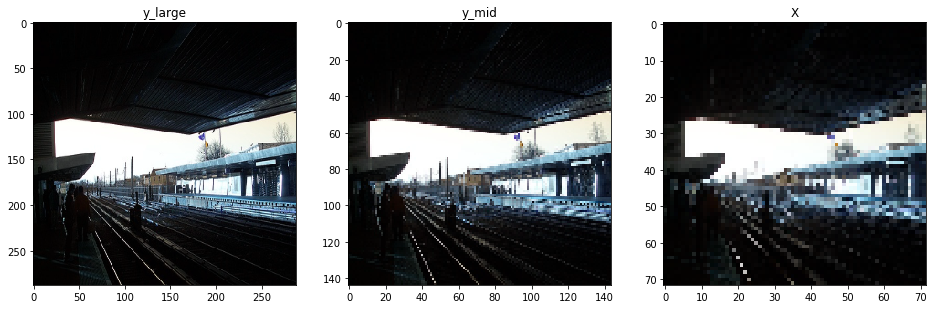

In [8]:
show_images(trainset[50])

In [9]:
class convnet(nn.Module):
    
    def __init__(self):
        super(convnet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample1 = nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1)
#         self.upsample1 = nn.Upsample(scale_factor=2.0, mode='nearest')
        self.conv3 = nn.Conv2d(64, 3, 1)
        
    def forward(self, x):
#         print('input shape: ', x.shape)
        x = self.conv1(x)
#         print('1st layer output shape: ', x.shape)
        x = self.conv2(F.leaky_relu(x))
#         print('2nd layer output shape: ', x.shape)
        x = self.upsample1(F.leaky_relu(x), output_size=(144, 144))
#         print('Upsample layer output shape: ', x.shape)
        x = self.conv3(F.leaky_relu(x))
#         print('final layer output shape: ', x.shape)
        return x

In [10]:
def train_model_y_mid(config, net, train_data, optimizer, epoch, loss_fn=None):
    net.train()
    train_loss = 0
    if loss_fn is None:
        loss_fn = nn.MSELoss()
    for i, batch in tqdm(enumerate(train_data), total=len(train_data)):
        X = batch['X']
        y_mid = batch['y_mid']
        optimizer.zero_grad()
        output = net(X)
        loss = loss_fn(output, y_mid)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    wandb.log({'Train Loss - Model 1': train_loss/len(train_data), 'Epoch': epoch}, commit=False)

def test_model_y_mid(config, net, test_data, epoch, loss_fn=None):
    net.eval()
    test_loss = 0
    example_images = []
    avg_psnr = 0
    n = len(test_data)
    if loss_fn is None:
        loss_fn = nn.MSELoss()
    with torch.no_grad():
        for j, batch in tqdm(enumerate(test_data), total=len(test_data)):
            X = batch['X']
            y_mid = batch['y_mid']
            output = net(X)
            loss = loss_fn(output, y_mid).item()
            test_loss += loss
            avg_psnr += 10 * np.log10(1/loss)
            example_images.append(wandb.Image(transforms.ToPILImage(mode='RGB')(output[0]), 
                                              caption="Output Reconstruction"))
            example_images.append(wandb.Image(transforms.ToPILImage(mode='RGB')(y_mid[0]), 
                                              caption="Target"))
    wandb.log({'Test Loss - Model 1': test_loss/n, "Examples": example_images, 'Epoch': epoch, 
              'Avg Peak Signal To Noise Ratio': avg_psnr/n})

In [11]:
def run_training(network):
    model = network().to(device)
    wandb.watch(model, log="all")
    optimizer = optim.Adam(model.parameters(), lr=config.lr)
    loss_fn = nn.MSELoss()
    for epoch in range(1, config.epochs + 1):
        train_model_y_mid(config, model, trainloader, optimizer, epoch, loss_fn)
        test_model_y_mid(config, model, testloader, epoch, loss_fn)
    return model

In [12]:
model1 = run_training(convnet)

100%|██████████| 4/4 [00:02<00:00,  1.70it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


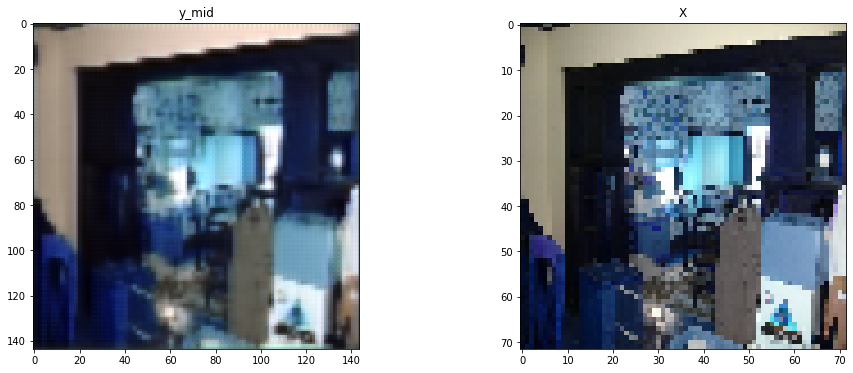

In [13]:
dataiter = iter(trainloader)
test = next(dataiter)
y_mid = model1(test['X'])
img_dct = dict(y_mid=y_mid[0], X=test['X'][0])
show_images(img_dct)

In [14]:
class convnet2(convnet):
    
    def __init__(self):
        super(convnet2, self).__init__()
        self.upsample2 = nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1)
        self.conv3_1 = nn.Conv2d(64, 3, 1)
        self.conv3_2 = nn.Conv2d(64, 3, 1)
    
    def forward(self, x):
        h, w = x.shape[-2:]
        x = self.conv1(x)
#         print('1st layer output shape: ', x.shape)
        x = self.conv2(F.leaky_relu(x))
#         print('2nd layer output shape: ', x.shape)
        x = self.upsample1(x, output_size=(h*2, w*2))
        h, w = x.shape[-2:]
#         print('Upsample layer output shape: ', x.shape)
        x = F.leaky_relu(x)
        x_mid = self.conv3_1(x)
        # print('final layer x_mid output shape: ', x_mid.shape)
        x_large = self.upsample2(x, output_size=(h*2, w*2))
        x_large = self.conv3_2(F.leaky_relu(x_large))
        # print('final layer x_large output shape: ', x_large.shape)
        return x_mid, x_large

In [15]:
def train_model_y_mid_large(config, net, train_data, optimizer, epoch, loss_fn=None, model_number=2):
    net.train()
    train_loss = 0
    if loss_fn is None:
        loss_fn = nn.MSELoss()
    for i, batch in tqdm(enumerate(train_data), total=len(train_data)):
        X = batch['X']
        y_mid = batch['y_mid']
        y_large = batch['y_large']
        optimizer.zero_grad()
        mid_output, large_output = net(X)
        loss = loss_fn(mid_output, y_mid) + loss_fn(large_output, y_large)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    wandb.log({f'Train Loss - Model {model_number}': train_loss/len(train_data), 'Epoch': epoch}, commit=False)

def test_model_y_mid_large(config, net, test_data, epoch, loss_fn=None, model_number=2):
    net.eval()
    test_loss = 0
    example_images = []
    avg_psnr = 0
    n = len(test_data)
    if loss_fn is None:
        loss_fn = nn.MSELoss()
    with torch.no_grad():
        for j, batch in tqdm(enumerate(test_data), total=len(test_data)):
            X = batch['X'].to(device)
            y_mid = batch['y_mid'].to(device)
            y_large = batch['y_large'].to(device)
            mid_output, large_output = net(X)
            loss = loss_fn(mid_output, y_mid).item() + loss_fn(large_output, y_large).item() 
            test_loss += loss
            avg_psnr += 10 * np.log10(1/loss)
            example_images.append(wandb.Image(transforms.ToPILImage(mode='RGB')(mid_output[0]), 
                                                caption="Mid Output Reconstruction"))
            example_images.append(wandb.Image(transforms.ToPILImage(mode='RGB')(large_output[0]), 
                                                caption="Large Output Reconstruction"))
            example_images.append(wandb.Image(transforms.ToPILImage(mode='RGB')(y_mid[0]), 
                                                caption="Target"))
    wandb.log({f'Test Loss - Model {model_number}': test_loss/len(test_data), "Examples": example_images, 'Epoch': epoch,
                'Avg Peak Signal To Noise Ratio': avg_psnr/n})

In [16]:
def run_training2(network, model_number):
    model = network().to(device)
    wandb.watch(model, log="all")
    wandb.re
    optimizer = optim.Adam(model.parameters(), lr=config.lr)
    loss_fn = nn.MSELoss()
    for epoch in range(1, config.epochs + 1):
        train_model_y_mid_large(config, model, trainloader, optimizer, epoch, loss_fn=loss_fn, model_number=model_number)
        test_model_y_mid_large(config, model, testloader, epoch, loss_fn=loss_fn, model_number=model_number)
    return model

In [17]:
model2 = run_training2(convnet2, model_number=2)

100%|██████████| 20/20 [01:14<00:00,  3.73s/it]
wandb: WARNING Adding to old History rows isn't currently supported.  Step 1 < 5; dropping {'Train Loss - Model 2': 1.6467583674937487}.
100%|██████████| 4/4 [00:07<00:00,  1.88s/it]
wandb: WARNING Adding to old History rows isn't currently supported.  Step 1 < 5; dropping {'Test Loss - Model 2': 0.05926754558458924, 'Examples': [<wandb.data_types.Image object at 0x13623a290>, <wandb.data_types.Image object at 0x135fddbd0>, <wandb.data_types.Image object at 0x135fddc50>, <wandb.data_types.Image object at 0x135fdd9d0>, <wandb.data_types.Image object at 0x135fdd450>, <wandb.data_types.Image object at 0x13625ec10>, <wandb.data_types.Image object at 0x135fdd0d0>, <wandb.data_types.Image object at 0x13625e750>, <wandb.data_types.Image object at 0x13625e390>, <wandb.data_types.Image object at 0x1119be2d0>, <wandb.data_types.Image object at 0x13623a390>, <wandb.data_types.Image object at 0x135947c50>]}.
100%|██████████| 20/20 [01:23<00:00,  4.18

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


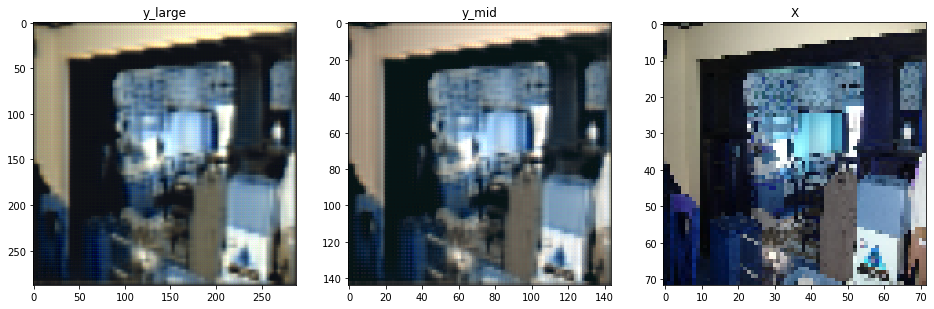

In [18]:
dataiter = iter(trainloader)
test = next(dataiter)
y_mid, y_large = model2(test['X'])
img_dct = dict(y_large=y_large[0], y_mid=y_mid[0], X=test['X'][0])
show_images(img_dct)

In [19]:
class resnet(nn.Module):
    
    def __init__(self):
        super(resnet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 1)
        self.res_block1_1 = nn.Conv2d(32,32, 3, padding=1)
        self.res_block1_2 = nn.Conv2d(32,32, 3, padding=1)
        self.res_block2_1 = nn.Conv2d(32,32, 3, padding=1)
        self.res_block2_2 = nn.Conv2d(32,32, 3, padding=1)
        self.upsample1 = nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1)
        self.res_block3_1 = nn.Conv2d(32,32, 3, padding=1)
        self.res_block3_2 = nn.Conv2d(32,32, 3, padding=1)
        self.upsample2 = nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1)
        self.conv3_1 = nn.Conv2d(32, 3, 1)
        self.conv3_2 = nn.Conv2d(32, 3, 1)

    def forward(self, x):
#         print('input shape: ', x.shape)
        h, w = x.shape[-2:]
        x = self.conv1(x)
        # print('1st layer output shape: ', x.shape)
        x_res = self.res_block1_1(x)
        x_res = self.res_block1_2(x_res)
        x = F.leaky_relu(x + x_res)
        # print('1st residual layer output shape: ', x.shape)
        x_res = self.res_block2_1(x)
        x_res = self.res_block2_2(x_res)
        x = F.leaky_relu(x_res + x)
        # print('2nd residual layer output shape: ', x.shape)
        x = self.upsample1(x, output_size=(h*2, w*2))
        h, w = x.shape[-2:]
        # print('1st Upsample layer output shape: ', x.shape)
        x_mid = self.conv3_1(F.leaky_relu(x))
        # print('final layer x_mid output shape: ', x_mid.shape)
        x_res = self.res_block3_1(x)
        x_res = self.res_block3_2(x_res)
        x = F.leaky_relu(x_res + x)
        x_large = self.upsample2(x, output_size=(h*2, w*2))
        # print('final layer x_large output shape: ', x_large.shape)
        x_large = self.conv3_2(F.leaky_relu(x_large))
        return x_mid, x_large

In [20]:
model3 = run_training2(resnet, model_number=3)

100%|██████████| 20/20 [00:52<00:00,  2.61s/it]
wandb: WARNING Adding to old History rows isn't currently supported.  Step 1 < 5; dropping {'Train Loss - Model 3': 0.883673007786274}.
100%|██████████| 4/4 [00:04<00:00,  1.10s/it]
wandb: WARNING Adding to old History rows isn't currently supported.  Step 1 < 5; dropping {'Test Loss - Model 3': 0.16671529039740562, 'Examples': [<wandb.data_types.Image object at 0x136233710>, <wandb.data_types.Image object at 0x1358852d0>, <wandb.data_types.Image object at 0x13588f650>, <wandb.data_types.Image object at 0x13639d3d0>, <wandb.data_types.Image object at 0x13588fcd0>, <wandb.data_types.Image object at 0x13586a150>, <wandb.data_types.Image object at 0x1358851d0>, <wandb.data_types.Image object at 0x135885050>, <wandb.data_types.Image object at 0x13588f850>, <wandb.data_types.Image object at 0x1358859d0>, <wandb.data_types.Image object at 0x13588fc90>, <wandb.data_types.Image object at 0x13588f410>]}.
100%|██████████| 20/20 [00:50<00:00,  2.51s

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


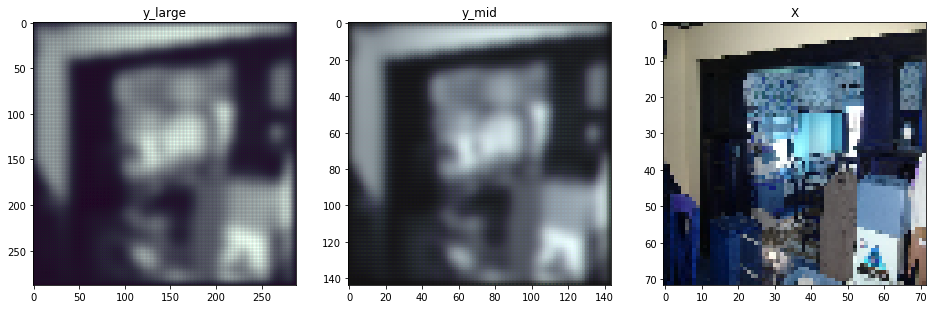

In [21]:
dataiter = iter(trainloader)
test = next(dataiter)
y_mid, y_large = model3(test['X'])
img_dct = dict(y_large=y_large[0], y_mid=y_mid[0], X=test['X'][0])
show_images(img_dct)

In [22]:
class dilation_net(nn.Module):
    
    def __init__(self):
        super(dilation_net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 1)
        self.dil_block1_1 = nn.Conv2d(32,32, 3, padding=1, dilation=1)
        self.dil_block1_2 = nn.Conv2d(32,32, 3, padding=2, dilation=2)
        self.dil_block1_3 = nn.Conv2d(32,32, 3, padding=4, dilation=4)
        self.dil_block1_4 = nn.Conv2d(96,32, 3, padding=1)
        self.dil_block2_1 = nn.Conv2d(32,32, 3, padding=1, dilation=1)
        self.dil_block2_2 = nn.Conv2d(32,32, 3, padding=2, dilation=2)
        self.dil_block2_3 = nn.Conv2d(32,32, 3, padding=4, dilation=4)
        self.dil_block2_4 = nn.Conv2d(96,32, 3, padding=1)
        self.dil_block3_1 = nn.Conv2d(32,32, 3, padding=1, dilation=1)
        self.dil_block3_2 = nn.Conv2d(32,32, 3, padding=2, dilation=2)
        self.dil_block3_3 = nn.Conv2d(32,32, 3, padding=4, dilation=4,)
        self.dil_block3_4 = nn.Conv2d(96,32, 3, padding=1)
        self.upsample1 = nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1)
        self.upsample2 = nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1)
        self.conv3_1 = nn.Conv2d(32, 3, 1)
        self.conv3_2 = nn.Conv2d(32, 3, 1)

    def forward(self, x):
        h, w = x.shape[-2:]
        x = self.conv1(x)
        # print('1st layer output shape: ', x.shape)
        x1 = self.dil_block1_1(x)
        # print('1st dilation output shape: ', x1.shape)
        x2 = self.dil_block1_2(x)
        # print('2nd dilation output shape: ', x2.shape)
        x3 = self.dil_block1_3(x)
        # print('3rd dilation output shape: ', x3.shape)
        x = self.dil_block1_4(F.leaky_relu(torch.cat([x1, x2, x3], dim=1)))
        # print('1st dilation layer output shape: ', x.shape)
        x1 = self.dil_block2_1(x)
        x2 = self.dil_block2_2(x)
        x3 = self.dil_block2_3(x)
        x = self.dil_block2_4(F.leaky_relu(torch.cat([x1, x2, x3], dim=1)))
        # print('2nd dilation layer output shape: ', x.shape)
        x = self.upsample1(x, output_size=(h*2, w*2))
        h, w = x.shape[-2:]
        # print('1st Upsample layer output shape: ', x.shape)
        x_mid = self.conv3_1(F.leaky_relu(x))
        # print('final layer x_mid output shape: ', x_mid.shape)
        x1 = self.dil_block3_1(x)
        x2 = self.dil_block3_2(x)
        x3 = self.dil_block3_3(x)
        x = self.dil_block3_4(F.leaky_relu(torch.cat([x1, x2, x3], dim=1)))
        x_large = self.upsample2(x, output_size=(h*2, w*2))
        # print('final layer x_large output shape: ', x_large.shape)
        x_large = self.conv3_2(F.leaky_relu(x_large))
        return x_mid, x_large

In [23]:
model4 = run_training2(dilation_net, model_number=4)

100%|██████████| 20/20 [01:43<00:00,  5.16s/it]
wandb: WARNING Adding to old History rows isn't currently supported.  Step 1 < 5; dropping {'Train Loss - Model 4': 238955.93172846438}.
100%|██████████| 4/4 [00:08<00:00,  2.01s/it]
wandb: WARNING Adding to old History rows isn't currently supported.  Step 1 < 5; dropping {'Test Loss - Model 4': 62074.37841796875, 'Examples': [<wandb.data_types.Image object at 0x13586d050>, <wandb.data_types.Image object at 0x136230650>, <wandb.data_types.Image object at 0x13586d6d0>, <wandb.data_types.Image object at 0x13586dc10>, <wandb.data_types.Image object at 0x1359268d0>, <wandb.data_types.Image object at 0x13586d610>, <wandb.data_types.Image object at 0x135357450>, <wandb.data_types.Image object at 0x13592ae50>, <wandb.data_types.Image object at 0x135357d10>, <wandb.data_types.Image object at 0x13625e710>, <wandb.data_types.Image object at 0x135357250>, <wandb.data_types.Image object at 0x1353570d0>]}.
100%|██████████| 20/20 [01:42<00:00,  5.12s/

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


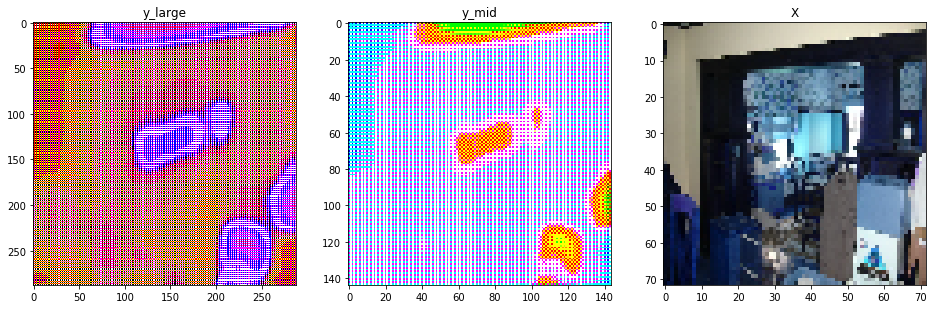

In [24]:
dataiter = iter(trainloader)
test = next(dataiter)
y_mid, y_large = model4(test['X'])
img_dct = dict(y_large=y_large[0], y_mid=y_mid[0], X=test['X'][0])
show_images(img_dct)

In [28]:
class pretrained_net(nn.Module):
    
    def __init__(self):
        super(pretrained_net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample1 = nn.ConvTranspose2d(128, 128, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 3, 1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.upsample2 = nn.ConvTranspose2d(128, 128, 3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(128, 3, 1)
        self.backbone = models.vgg16(pretrained=True)._modules['features'][:4]
        for param in self.backbone.parameters():
            param.requires_grad = False

    def forward(self, x):
        h, w = x.shape[-2:]
        out = self.backbone(x)
        # print('backbone layer output shape: ', out.shape)
        x = F.leaky_relu(self.conv1(x))
        # print('1st layer output shape: ', x.shape)
        x = F.leaky_relu(self.conv2(x))
        # print('2nd layer output shape: ', x.shape)
        x = torch.cat([x, out], dim=1)
        # print('Concatenated output shape: ', x.shape)
        x = self.upsample1(x, output_size=(h*2, w*2))
        # print('1st upsample layer output shape: ', x.shape)
        h, w = x.shape[-2:]
        x_mid = F.leaky_relu(self.conv3(x))
        # print('Mid_output shape: ', x_mid.shape)
        x = F.leaky_relu(self.conv4(x))
        # print('4th conv layer output shape: ', x.shape)
        x_large = self.upsample2(x, output_size=(h*2, w*2))
        # print('2nd upsample layer output shape: ', x_large.shape)
        x_large = F.leaky_relu(self.conv5(x_large))
        # print('x_large output shape: ', x_large.shape)
        return x_mid, x_large

In [29]:
model5 = run_training2(pretrained_net, model_number=5)

100%|██████████| 20/20 [04:52<00:00, 14.61s/it]
wandb: WARNING Adding to old History rows isn't currently supported.  Step 1 < 5; dropping {'Train Loss - Model 5': 4.424009299278259}.
100%|██████████| 4/4 [00:21<00:00,  5.41s/it]
wandb: WARNING Adding to old History rows isn't currently supported.  Step 1 < 5; dropping {'Test Loss - Model 5': 0.6716885156929493, 'Examples': [<wandb.data_types.Image object at 0x135b6c7d0>, <wandb.data_types.Image object at 0x1362c9ed0>, <wandb.data_types.Image object at 0x135672510>, <wandb.data_types.Image object at 0x136fc4410>, <wandb.data_types.Image object at 0x136fc5a10>, <wandb.data_types.Image object at 0x136fc5550>, <wandb.data_types.Image object at 0x136fc4f50>, <wandb.data_types.Image object at 0x136623d50>, <wandb.data_types.Image object at 0x136fc5250>, <wandb.data_types.Image object at 0x136fc5f50>, <wandb.data_types.Image object at 0x136fc5d50>, <wandb.data_types.Image object at 0x136fc5190>]}.
100%|██████████| 20/20 [05:30<00:00, 16.53s/

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


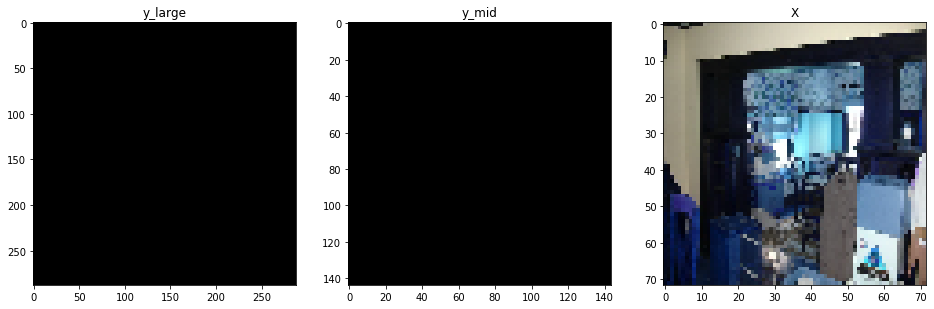

In [30]:
dataiter = iter(trainloader)
test = next(dataiter)
y_mid, y_large = model5(test['X'])
img_dct = dict(y_large=y_large[0], y_mid=y_mid[0], X=test['X'][0])
show_images(img_dct)

In [46]:
class pixel_shuffle_net(pretrained_net):
    
    def __init__(self):
        super(pixel_shuffle_net, self).__init__()
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 192, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 3, 1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv5 = nn.Conv2d(32, 3, 1)
    def forward(self, x):
        h, w = x.shape[-2:]
        out = self.backbone(x)
        print('backbone layer output shape: ', out.shape)
        x = F.leaky_relu(self.conv1(x))
        print('1st layer output shape: ', x.shape)
        x = F.leaky_relu(self.conv2_1(x))
        print('2_1 layer output shape: ', x.shape)
        x = F.leaky_relu(self.conv2_2(x))
        print('2_2 layer output shape: ', x.shape)
        x = torch.cat([x, out], dim=1)
        print('Concatenated output shape: ', x.shape)
        x = F.pixel_shuffle(x, upscale_factor=2)
        print('1st upsample layer output shape: ', x.shape)
        h, w = x.shape[-2:]
        x_mid = F.leaky_relu(self.conv3(x))
        print('Mid_output shape: ', x_mid.shape)
        x = F.leaky_relu(self.conv4(x))
        print('4th conv layer output shape: ', x.shape)
        x_large = F.pixel_shuffle(x, upscale_factor=2)
        print('2nd upsample layer output shape: ', x_large.shape)
        x_large = F.leaky_relu(self.conv5(x_large))
        print('x_large output shape: ', x_large.shape)
        return x_mid, x_large

In [47]:
model6 = run_training2(pixel_shuffle_net, model_number=6)

0%|          | 0/20 [00:00<?, ?it/s]backbone layer output shape:  torch.Size([5, 64, 72, 72])
1st layer output shape:  torch.Size([5, 64, 72, 72])
2_1 layer output shape:  torch.Size([5, 128, 72, 72])
2_1 layer output shape:  torch.Size([5, 192, 72, 72])
Concatenated output shape:  torch.Size([5, 256, 72, 72])
1st upsample layer output shape:  torch.Size([5, 64, 144, 144])
Mid_output shape:  torch.Size([5, 3, 144, 144])
4th conv layer output shape:  torch.Size([5, 128, 144, 144])
2nd upsample layer output shape:  torch.Size([5, 32, 288, 288])
x_large output shape:  torch.Size([5, 3, 288, 288])
  5%|▌         | 1/20 [00:17<05:35, 17.64s/it]backbone layer output shape:  torch.Size([5, 64, 72, 72])
1st layer output shape:  torch.Size([5, 64, 72, 72])
2_1 layer output shape:  torch.Size([5, 128, 72, 72])
2_1 layer output shape:  torch.Size([5, 192, 72, 72])
Concatenated output shape:  torch.Size([5, 256, 72, 72])
1st upsample layer output shape:  torch.Size([5, 64, 144, 144])
Mid_output sh

KeyboardInterrupt: 

In [ ]:
dataiter = iter(trainloader)
test = next(dataiter)
y_mid, y_large = model6(test['X'])
img_dct = dict(y_large=y_large[0], y_mid=y_mid[0], X=test['X'][0])
show_images(img_dct)